This code is written by Kuba Jerzmanowski
This code is inspired and based on strongly from Andrej Karpathy Micro Grad Video

In [261]:
import math
import random
import numpy as np

In [262]:
class Scalar:
    def __init__(self, data, _children=(), _op=''): 
        self.data = data
        self.grad = 0
        self.op = _op
        self._backward = lambda: None
        self._prev = set(_children)
    
    def __repr__(self):
        return f'Scalar(data={self.data})'
    
    def __add__(self, other):  #define add and the back prob for it 
        other = other if isinstance(other, Scalar) else Scalar(other) #this helps so we can pass in raw numbers
        out = Scalar(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): #so the sum() works
        return self + other
    
    def __mul__(self, other): #define multiplication and the back prob for it 
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): 
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rmul__(self, other):
        return self * other
    

    def __pow__(self, other):
        out = Scalar(self.data ** other, (self, ), f'^{other}')

        def _backward():
            self.grad += out.grad * other * (self.data**(other-1))
        out._backward = _backward
        return out
 
    def tanh(self):
        t = (math.exp(2*self.data)-1)/(math.exp(2*self.data) + 1)
        out = Scalar(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    

    def sigmoid(self):
        s = 1 / (1 + np.exp(-self.data))
        out = Scalar(s, (self,), 'sigmoid')

        def _backward():
            self.grad += s * (1 - s) * out.grad
        out._backward = _backward

        return out
    
    def backprop(self): #we first build up the topo list then reverse it since we backprop in reverse starting with the Scalar representing the Loss
        self.grad = 1

        chain = []
        seen = set()
        def build_list(node):
            if node not in seen:
                seen.add(node)
                for par in node._prev:
                    build_list(par)
                chain.append(node)

        build_list(self)
        for node in reversed(chain):
            node.grad
            node._backward()

Define the NN 

In [263]:
from typing import Any


class Neuron:
    def __init__(self, width):
        #each neuron has weights to where they are the input width and an additional bias
        self.w = [Scalar(random.uniform(-1,1)) for _ in range(width+1)]
        self.b = Scalar(random.uniform(-1,1))

    def __call__(self, x):
        #here we want to miltiply so we will zip the weights to do wx+b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.sigmoid()
    
    def params(self): #this function is nesscary so that we can later update each param after getting the grad
        return self.w + [self.b]
    
class Layer: #here we just move up another layer of abstraction where we will 
    def __init__(self, num_in, num_out):
        self.neurons = [Neuron(num_in) for _ in range(num_out)]

    def __call__(self, x):
        return [n(x) for n in self.neurons]
    
    def params(self):
        params = []
        for n in self.neurons:
            p = n.params()
            params.extend(p)
        return params
    
class MLP: 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def params(self):
        params = []
        for l in self.layers:
            p = l.params()
            params.extend(p)
        return params
    
    def optim(self):
        for param in self.params():
           param.data += -0.001 * param.grad



Define the loss function. We have to double unpack because y is 2 outputs

In [264]:
def MSE(y_pred, y_true):
    def single_mse(pl, tl):
        return sum([(p-t)**2 for p, t in zip(pl, tl)])

    losses = [single_mse(pl, tl) for pl, tl in zip(y_pred, y_true)]
    data_loss = sum(losses) * (1.0 / len(losses))
    return data_loss


Def the Data

In [265]:
X = [
    [0.1, 1.2],
    [0.7, 1.8],
    [0.8, 1.6],
    [0.8, 0.6],
    [1.0, 0.8],
    [0.3, 0.5],
    [0.0, 0.2],
    [-0.3, 0.8],
    [-0.5, -1.5],
    [-1.5, -1.3]
]

Y = [
    [1,0],
    [1,0],
    [1,0],
    [0,0],
    [0,0],
    [1,1],
    [1,1],
    [1,1],
    [0,1],
    [0,1],
]

nn = MLP(2, [15,2])
lossi = [] #accumulate the loss

In [266]:
Y_l = [
    1,
    1,
    1,
    0,
    0,
    3,
    3,
    3,
    2,
    2,
]

In [267]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, epoch):
    X_np = np.array(X)
    
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    inp = np.c_[xx.ravel(), yy.ravel()]
    Z = np.zeros((inp.shape[0],))
    for i, p in enumerate(inp):
        out = model(p)
        out[0] = 0 if out[0].data < 0.5 else 1
        out[1] = 0 if out[1].data < 0.5 else 1
        if out == [0,0]:
            Z[i] = 0 
        elif out == [1,0]:
            Z[i] = 1       
        elif out == [0,1]:
            Z[i] = 2
        elif out == [1,1]:
            Z[i] = 3
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.tricontourf(inp[:, 0], inp[:, 1], Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_l, cmap=plt.cm.RdYlBu, edgecolor='black')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f'Decision Boundary after {epoch} epochs')
    plt.colorbar()
    plt.show()

Train Looop

epoch: 0 loss: 0.6001926866394551
epoch: 1 loss: 0.600124607196139
epoch: 2 loss: 0.5999885022993641


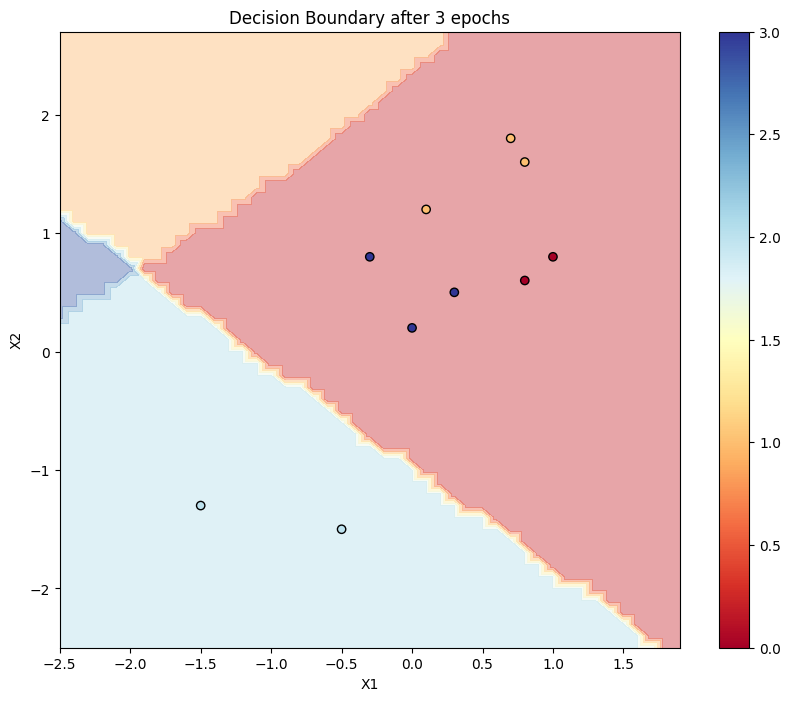

epoch: 3 loss: 0.5997844804281363
epoch: 4 loss: 0.5995127055498681
epoch: 5 loss: 0.5991733986208899
epoch: 6 loss: 0.5987668395899644
epoch: 7 loss: 0.5982933699068085
epoch: 8 loss: 0.5977533955375971
epoch: 9 loss: 0.5971473904890163


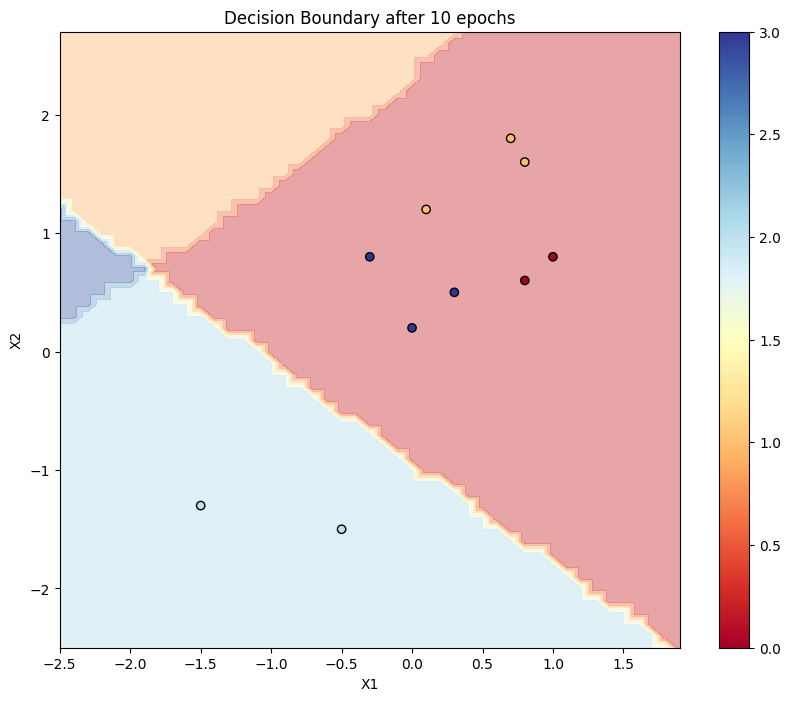

epoch: 10 loss: 0.5964759008415967
epoch: 11 loss: 0.5957395492916719
epoch: 12 loss: 0.5949390401993109
epoch: 13 loss: 0.594075165136864
epoch: 14 loss: 0.5931488089292372
epoch: 15 loss: 0.5921609561725857
epoch: 16 loss: 0.5911126982126989
epoch: 17 loss: 0.5900052405578207
epoch: 18 loss: 0.5888399106929677
epoch: 19 loss: 0.587618166253838
epoch: 20 loss: 0.5863416035081506
epoch: 21 loss: 0.5850119660806253
epoch: 22 loss: 0.5836311538448196
epoch: 23 loss: 0.5822012318907116
epoch: 24 loss: 0.580724439461316
epoch: 25 loss: 0.5792031987348607
epoch: 26 loss: 0.5776401233113488
epoch: 27 loss: 0.5760380262439277
epoch: 28 loss: 0.5743999274367232
epoch: 29 loss: 0.5727290602121509
epoch: 30 loss: 0.5710288768326696
epoch: 31 loss: 0.5693030527451935
epoch: 32 loss: 0.5675554893016344
epoch: 33 loss: 0.5657903146971539
epoch: 34 loss: 0.5640118828596266
epoch: 35 loss: 0.5622247700204837
epoch: 36 loss: 0.5604337686996417
epoch: 37 loss: 0.5586438788465831
epoch: 38 loss: 0.55686

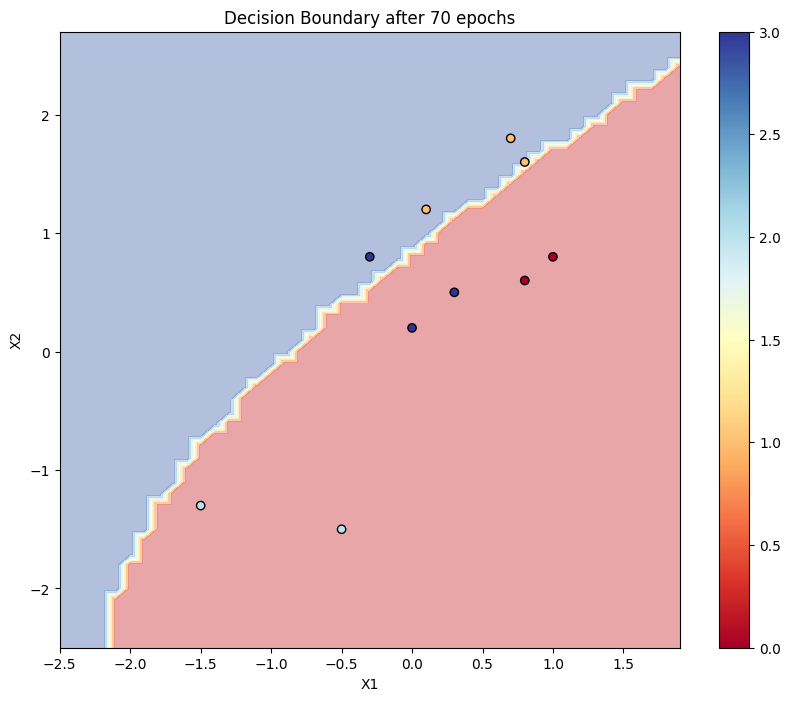

epoch: 70 loss: 0.5330214420995527
epoch: 71 loss: 0.5337763821924637
epoch: 72 loss: 0.5346033904770298
epoch: 73 loss: 0.5354968075271336
epoch: 74 loss: 0.5364507534223235
epoch: 75 loss: 0.5374591781987206
epoch: 76 loss: 0.5385159112485224
epoch: 77 loss: 0.5396147089978247
epoch: 78 loss: 0.540749300280499
epoch: 79 loss: 0.5419134289207035
epoch: 80 loss: 0.5431008931345129
epoch: 81 loss: 0.5443055814587705
epoch: 82 loss: 0.545521505009598
epoch: 83 loss: 0.5467428259615816
epoch: 84 loss: 0.5479638822195855
epoch: 85 loss: 0.5491792083270057
epoch: 86 loss: 0.5503835527162453
epoch: 87 loss: 0.5515718914588548
epoch: 88 loss: 0.552739438714169
epoch: 89 loss: 0.5538816541067624
epoch: 90 loss: 0.5549942472852615
epoch: 91 loss: 0.5560731799288425
epoch: 92 loss: 0.5571146654740625
epoch: 93 loss: 0.558115166834564
epoch: 94 loss: 0.5590713923807092
epoch: 95 loss: 0.5599802904363693
epoch: 96 loss: 0.5608390425369035
epoch: 97 loss: 0.5616450556767028
epoch: 98 loss: 0.562395

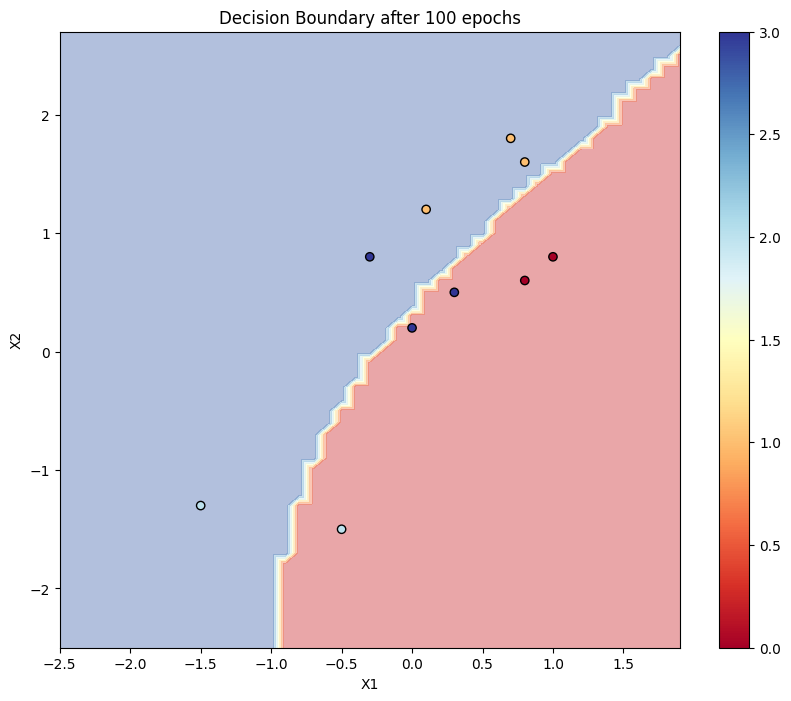

In [272]:
for epoch in range(100):
    y_pred = [nn(x) for x in X]
    loss = MSE(y_pred, Y)
    lossi.append(loss.data)
    print(f'epoch: {epoch} loss: {loss.data}')
    loss.backprop()
    nn.optim()

    if epoch + 1 in [3, 10, 70, 100]:
        plot_decision_boundary(nn, epoch + 1)

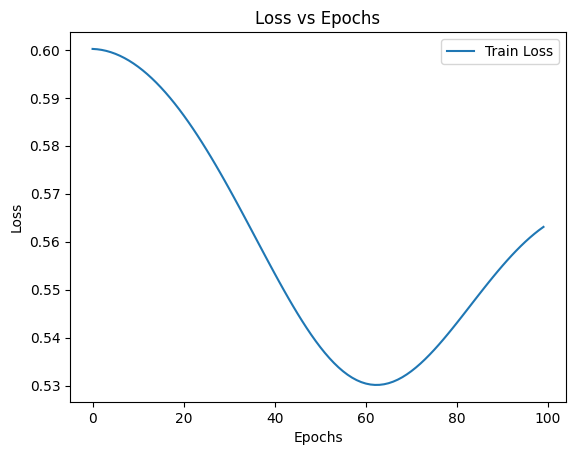

In [273]:
# Plot losses
plt.plot(lossi, label='Train Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()